In [1]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 58.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 68.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3


# Imports

In [2]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
from transformers import pipeline, AutoImageProcessor, AutoModelForDepthEstimation

2024-05-02 12:28:15.859385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 12:28:15.859524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 12:28:16.043978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Model

In [3]:
class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

# Depth Estimation Model Instances

In [4]:
# When inferring model through pipeline
pipe_small = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
pipe_large = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-large-hf")

# When inferring model Manually
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

# Step1: Extract Object Boundary Contours

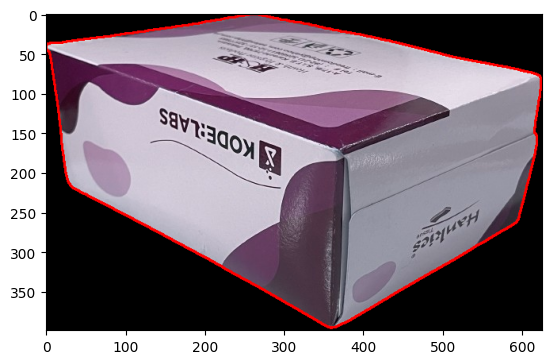

In [5]:
# Read Image RGB Image
rgb_image = cv2.imread("/kaggle/input/key-images/tissue_box_trans.png")
rgb_image_copy = rgb_image.copy()

# Convert it into gray-scale
imgray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

# Find top contour
contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(rgb_image_copy, contours, -1, (255, 0, 0), 2)

# Show contour
plt.imshow(rgb_image_copy)

In [6]:
# Make point objects
contour_points = []

for contour in contours:
    for point in contour:
        x,y = point[0]
        contour_points.append(Point(x,y,0))

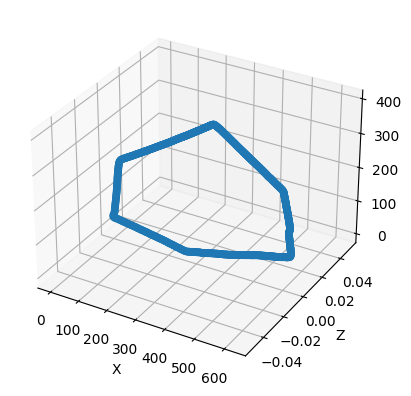

In [7]:
# Extract coordinates for plotting
x_vals = [point.x for point in contour_points]
y_vals = [point.y for point in contour_points]
z_vals = [point.z for point in contour_points]


# Plot the points in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_vals, z_vals, y_vals)

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

# ax.invert_zaxis()

plt.show()

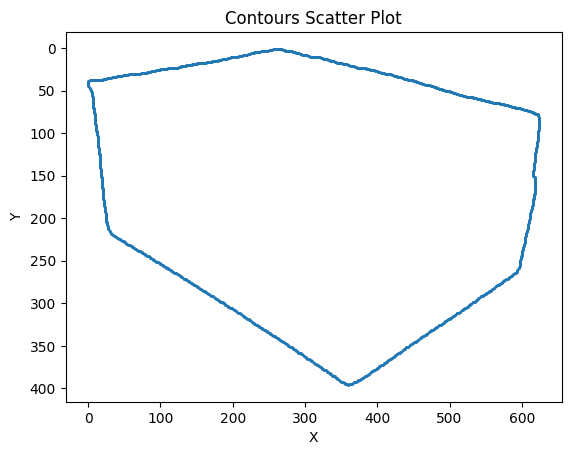

In [8]:
# Create a new figure
plt.figure()

x_vals = [point.x for point in contour_points]
y_vals = [point.y for point in contour_points]

plt.scatter(x_vals, y_vals, s=1)

# Set plot title and labels
plt.title("Contours Scatter Plot")
plt.xlabel("X")
plt.ylabel("Y")

# Invert y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

# Step2: Find Object Depth

(626, 399)


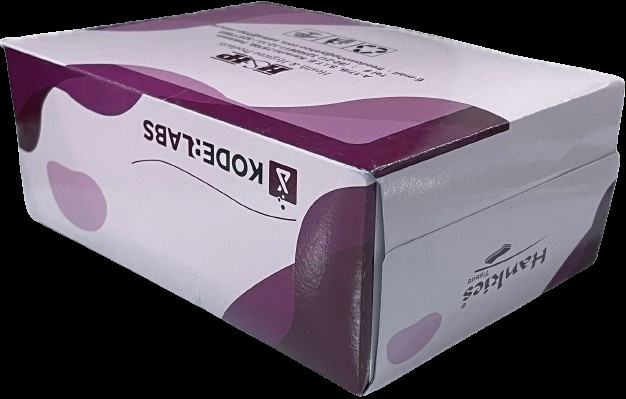

In [9]:
image = Image.fromarray(rgb_image)
print(image.size)
image

In [10]:
# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [11]:
prediction

tensor([[[[0.1617, 0.1908, 0.1960,  ..., 0.2554, 0.2371, 0.2238],
          [0.1726, 0.1798, 0.1791,  ..., 0.2304, 0.2276, 0.2587],
          [0.1623, 0.1770, 0.1704,  ..., 0.2340, 0.2403, 0.2712],
          ...,
          [8.3911, 8.3174, 8.3038,  ..., 8.8603, 8.8452, 8.7935],
          [8.0639, 8.1979, 8.3069,  ..., 8.8071, 8.6594, 8.4890],
          [7.1983, 7.9785, 8.3457,  ..., 8.6986, 8.3267, 8.0462]]]])

In [12]:
predicted_depth

tensor([[[0.1640, 0.1966, 0.1853,  ..., 0.2624, 0.2425, 0.2267],
         [0.1730, 0.1773, 0.1691,  ..., 0.2390, 0.2194, 0.2653],
         [0.1548, 0.1824, 0.1572,  ..., 0.2487, 0.2465, 0.2673],
         ...,
         [8.3307, 8.3140, 8.3020,  ..., 8.8545, 8.8550, 8.8501],
         [8.2882, 8.2615, 8.3233,  ..., 8.8541, 8.8004, 8.6389],
         [7.3001, 8.2187, 8.3145,  ..., 8.8518, 8.4774, 8.0948]]])

In [13]:
print(len(prediction[0][0][0])) # Width
print(len(prediction[0][0])) # Height

626
399


In [14]:
h, w = image.size[::-1]

depth = torch.nn.functional.interpolate(predicted_depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]

raw_depth = Image.fromarray(depth.cpu().numpy().astype('uint16'))
raw_depth.save("predicted_depth.png")

depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.cpu().numpy().astype(np.uint8)
colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

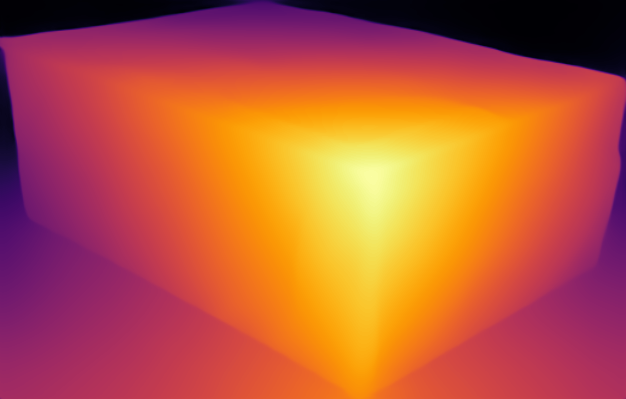

In [15]:
Image.fromarray(colored_depth)

# Step3: Adding z-axis values of each point using the depth values